# Random Forest - Weak Learners

Our modeling with random forest showed promising performance, to build on that we'll work on building some weak learnings and boosted random forests.

We'll build 3 vanilla boosted models:

- Adaboost
- Gradient Boost
- XGboost

In [1]:
# import libraries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTENC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectPercentile

from xgboost import XGBRFClassifier

from src.seed import SEED
from src.helper import confmat, praf1

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load our data, split our data
train = pd.read_csv("../data/processed/train.csv")

X = train.iloc[:, :-1]
y = train.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y)

In [3]:
# account for class imbalance in training data
sm = SMOTENC(np.arange(19, 69), random_state=SEED, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train, y_train)

## Baseline Models

In [4]:
# train, and predict
ada = AdaBoostClassifier()
gb = GradientBoostingClassifier()
xgb = XGBRFClassifier()

predictions = []
for clf in [ada, gb, xgb]:
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    predictions.append([train_pred, test_pred])

In [5]:
# output model results
results = []
for model, preds in zip(["AdaBoost", "GradientBoost", "XGBoost"], predictions):
    a = praf1(y_train, preds[0], "Training")
    b = praf1(y_test, preds[1], "Testing")
    
    df = pd.concat([a, b])
    df["model"] = model
    
    results.append(df)

pd.concat(results)

,precision,recall,accuracy,f1,model
Training,0.911425,0.885839,0.899875,0.898450,AdaBoost
Testing,0.550562,0.538462,0.868800,0.544444,AdaBoost
Training,0.973265,0.953837,0.963818,0.963453,GradientBoost
Testing,0.677419,0.692308,0.907200,0.684783,GradientBoost
Training,0.969533,0.893325,0.932626,0.929870,XGBoost
Testing,0.669903,0.758242,0.910400,0.711340,XGBoost


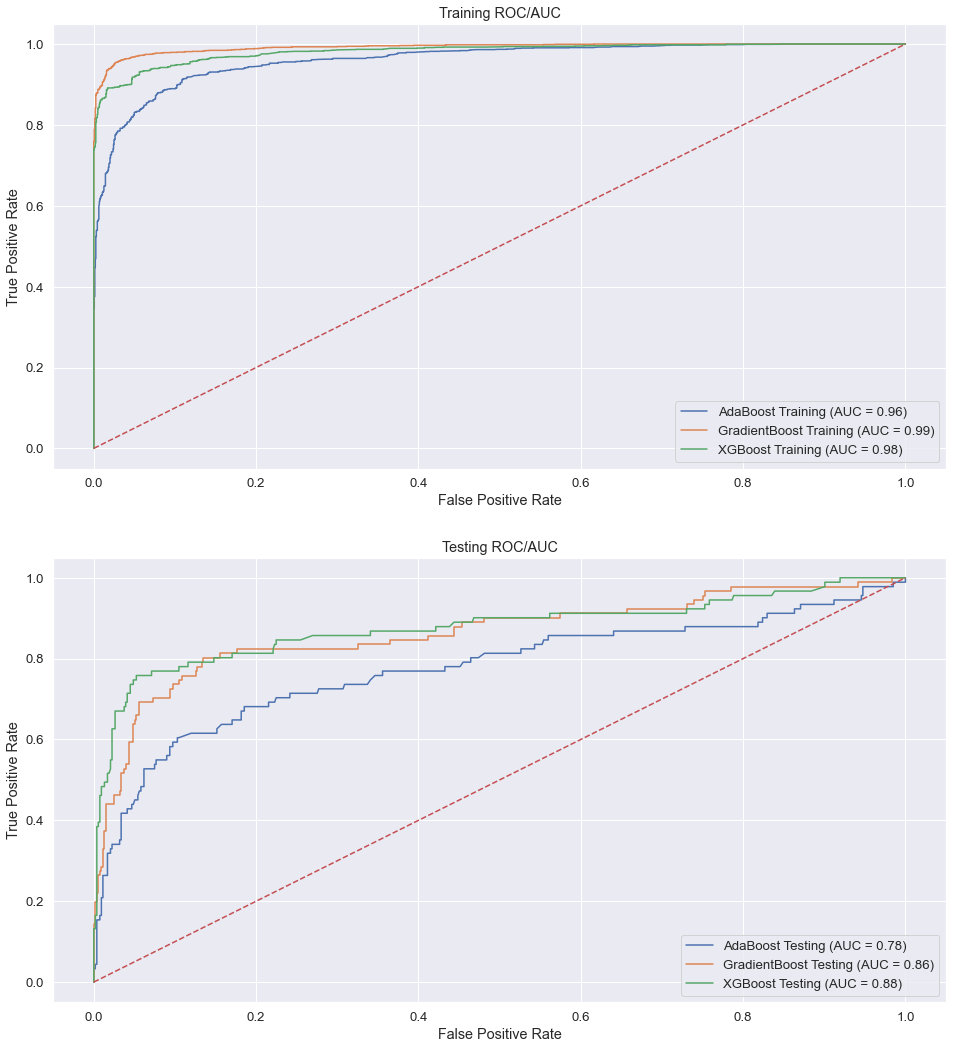

In [6]:
# Output ROC/AUC curves
fig, ax = plt.subplots(nrows=2, figsize=(16, 18))

for clf, model in ([ada, "AdaBoost"], [gb, "GradientBoost"], [xgb, "XGBoost"]):
    plot_roc_curve(clf, X_train, y_train, name=f"{model} Training", ax=ax[0])

for clf, model in ([ada, "AdaBoost"], [gb, "GradientBoost"], [xgb, "XGBoost"]):
    plot_roc_curve(clf, X_test, y_test, name=f"{model} Testing", ax=ax[1])

line = np.linspace(0, 1)
ax[0].plot(line, line, "--")
ax[0].set_title("Training ROC/AUC")
ax[1].plot(line, line, "--")
ax[1].set_title("Testing ROC/AUC")


plt.show()

The most promising of our 3 baseline models is our XGBoost model. It has a greater AUC than our previously created optimized Random Forest classifier, it also has a recall > precision, while maintaining a accuracy above 90%, and an f1 score greater than our Adaboost and Gradient boosted models.

## XGBoost Hyper Parameter Tuning

In [7]:
# create parameter grid and random search
param_grid = {
    "n_estimators": np.arange(100, 1000, 10),
    "max_depth": np.arange(1, 16),
    "learning_rate": stats.uniform(),
    "reg_alpha": stats.uniform(),
    "reg_lambda": stats.uniform(),
}

rs = RandomizedSearchCV(
    XGBRFClassifier(n_jobs=-1, random_state=SEED),
    param_grid,
    n_iter=50,
    scoring="f1",
    n_jobs=-1,
    random_state=SEED,
)
rs.fit(X_train, y_train)
print(rs.best_params_)

{'learning_rate': 0.11199696303472373, 'max_depth': 12, 'n_estimators': 860, 'reg_alpha': 0.1614370835214003, 'reg_lambda': 0.1507338330761262}


In [8]:
# get predictions and output training/testing results
train_pred = rs.predict(X_train)
test_pred = rs.predict(X_test)

a = praf1(y_train, train_pred, "Training")
b = praf1(y_test, test_pred, "Testing")
pd.concat([a, b])

,precision,recall,accuracy,f1
Training,0.987952,0.971928,0.980037,0.979874
Testing,0.690722,0.736264,0.913600,0.712766


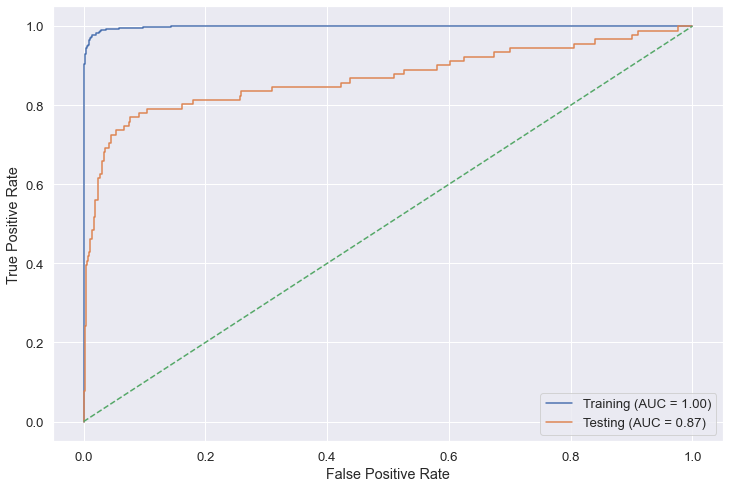

In [9]:
# output roc/auc curve
fig, ax = plt.subplots(figsize=(12, 8))

plot_roc_curve(rs, X_train, y_train, name="Training", ax=ax)
plot_roc_curve(rs, X_test, y_test, name="Testing", ax=ax)

line = np.linspace(0, 1)
plt.plot(line, line, "--")

plt.show()

Our AUC score has dropped .01, and our f1_score has increased by .1%. Looking through just 50 random models has resulted in a sizeable computational cost. We may need to do a more exhaustive search, or increase the amount of models we randomly create. 